Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Database contains 411 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Database contains 367 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...
Database contains 402 images


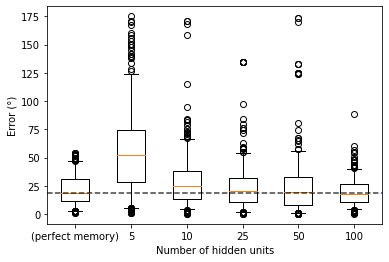

In [2]:
import sys

NAVBENCH_PATH = '../navbench'
sys.path.append(NAVBENCH_PATH)

import json
import os
import matplotlib.pyplot as plt
import navbench as nb
import numpy as np

def read_json(filepath):
    file = open(filepath, "r")
    data = json.load(file)["data"]
    file.close()
    return data

data = read_json('benchmark_infomax_multi.json')

DB_ROOT = os.path.join(NAVBENCH_PATH, "datasets/rc_car/Stanmer_park_dataset")

def get_training_data(routes):
    x_train = []
    y_train = []
    heads_train = []
    for dbname in routes:
        db = nb.Database(os.path.join(DB_ROOT, dbname))
        offset = db.calculate_heading_offset(0.25)

        for x in db.x:
            x_train.append(x)
        for y in db.y:
            y_train.append(y)
        
        cur_heads = np.deg2rad(db.heading) + offset
        for head in cur_heads:
            heads_train.append(head)
    
    return np.array(x_train), np.array(y_train), np.array(heads_train)

x_train, y_train, heads_train = get_training_data(data['experiments'][0]['training']['routes'])

db_test = nb.Database(os.path.join(DB_ROOT, data['experiments'][0]['testing']['routes'][0]))
offset = db_test.calculate_heading_offset(0.25)

def get_test_data(db_test, x_train, y_train, heads_train, expt, offset):
    heads = offset + np.deg2rad(expt['testing']['headings_deg'])
    errors = []
    for entry, (x, y, head) in enumerate(zip(db_test.x, db_test.y, heads)):
        distances = np.abs(np.hypot(x - x_train, y - y_train))
        best_match = np.argmin(distances)
        
        error = np.rad2deg(head - heads_train[best_match])
        while error > 180:
            error -= 360
        while error <= -180:
            error += 360
        error = np.abs(error)
        errors.append(error)

    return errors


errors = np.empty((len(db_test), 1 + len(data['experiments'])))
data_pm = read_json('benchmark_pm.json')
errors[:, 0] = get_test_data(db_test, x_train, y_train, heads_train, data_pm['experiments'][0], offset)
for expt_idx, expt in enumerate(data['experiments']):
    errors[:, 1+expt_idx] = get_test_data(db_test, x_train, y_train, heads_train, expt, offset)

fig, ax = plt.subplots()
ax.boxplot(errors, whis=(5, 95))
med = np.median(errors[:, 0])
ax.hlines(med, *ax.get_xlim(), 'k', '--', alpha=0.75, zorder=100)
ax.set_xticklabels(['(perfect memory)', *data['num_hiddens']])
ax.set_xlabel('Number of hidden units')
ax.set_ylabel('Error (°)')

fig.savefig('figures/num_hidden_boxplot.svg', bbox_inches='tight');